In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import os

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
latent_dim = 20
batch_size = 128
lr = 1e-3
epochs = 10
save_path = "./vae_mnist.pth"

In [8]:
transform = transforms.Compose([transforms.ToTensor()])  # values in [0,1]
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.latent_dim = latent_dim
        # encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        # decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid(),  # output in [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder_fc(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [10]:
def vae_loss(recon_x, x, mu, logvar):
    # BCE as reconstruction (sum over pixels)
    bce = nn.functional.binary_cross_entropy(recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    # KL divergence between q(z|x)=N(mu, sigma^2) and p(z)=N(0,I)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld, bce, kld


In [11]:
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)



In [12]:
model.train()
for epoch in range(1, epochs+1):
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader, 1):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 200 == 0:
            print(f"Epoch {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}] "
                  f"Loss: {loss.item():.1f} (BCE {bce.item():.1f}, KLD {kld.item():.1f})")

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average loss: {avg_loss:.4f}")


Epoch 1 [25600/60000] Loss: 18886.3 (BCE 16720.0, KLD 2166.3)
Epoch 1 [51200/60000] Loss: 16848.2 (BCE 14229.2, KLD 2619.0)
====> Epoch: 1 Average loss: 164.0815
Epoch 2 [25600/60000] Loss: 15543.9 (BCE 12707.5, KLD 2836.4)
Epoch 2 [51200/60000] Loss: 15274.8 (BCE 12241.7, KLD 3033.2)
====> Epoch: 2 Average loss: 121.3989
Epoch 3 [25600/60000] Loss: 14954.2 (BCE 11789.4, KLD 3164.7)
Epoch 3 [51200/60000] Loss: 14460.3 (BCE 11275.9, KLD 3184.4)
====> Epoch: 3 Average loss: 114.7203
Epoch 4 [25600/60000] Loss: 14133.9 (BCE 11007.8, KLD 3126.1)
Epoch 4 [51200/60000] Loss: 14210.7 (BCE 11047.6, KLD 3163.1)
====> Epoch: 4 Average loss: 111.8465
Epoch 5 [25600/60000] Loss: 13974.1 (BCE 10733.1, KLD 3241.0)
Epoch 5 [51200/60000] Loss: 13996.0 (BCE 10747.4, KLD 3248.7)
====> Epoch: 5 Average loss: 110.1010
Epoch 6 [25600/60000] Loss: 14711.4 (BCE 11359.6, KLD 3351.8)
Epoch 6 [51200/60000] Loss: 13812.8 (BCE 10683.8, KLD 3129.0)
====> Epoch: 6 Average loss: 108.9317
Epoch 7 [25600/60000] Loss: 

In [13]:
os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
torch.save(model.state_dict(), save_path)
print("Saved model to", save_path)

Saved model to ./vae_mnist.pth


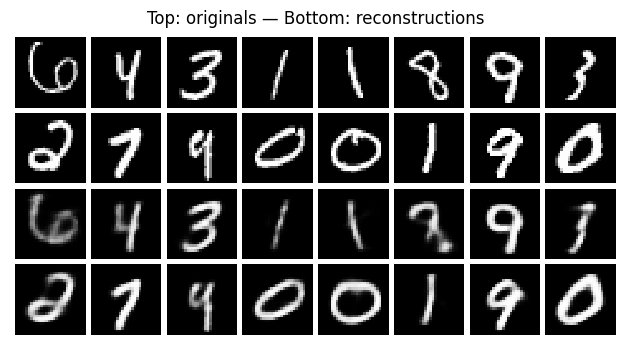

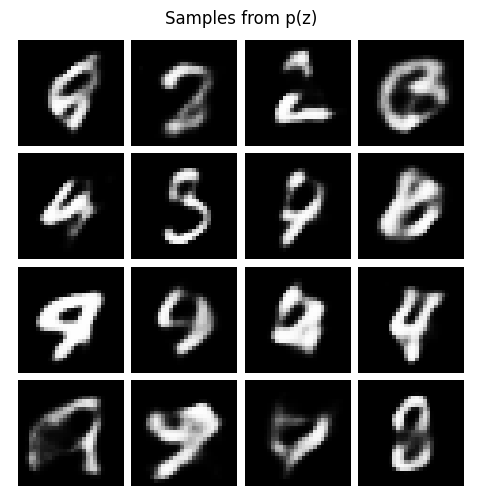

In [14]:
model.eval()
with torch.no_grad():
    # get a small batch of test images
    test_batch = next(iter(DataLoader(train_ds, batch_size=16, shuffle=True)))
    imgs = test_batch[0].to(device)
    recon, _, _ = model(imgs)

    # show originals (top row) and reconstructions (bottom row)
    comparison = torch.cat([imgs.cpu(), recon.cpu()])
    grid = utils.make_grid(comparison, nrow=8, pad_value=1.0)
    plt.figure(figsize=(10,4))
    plt.axis('off')
    plt.title("Top: originals — Bottom: reconstructions")
    plt.imshow(grid.permute(1,2,0).squeeze(), interpolation='nearest')
    plt.show()

    # sample from prior p(z) and decode
    z = torch.randn(16, latent_dim).to(device)
    samples = model.decode(z).cpu()
    grid2 = utils.make_grid(samples, nrow=4, pad_value=1.0)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.title("Samples from p(z)")
    plt.imshow(grid2.permute(1,2,0).squeeze(), interpolation='nearest')
    plt.show()